In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score, PrecisionRecallDisplay, RocCurveDisplay

from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [22]:
# read data
df = pd.read_csv('https://raw.githubusercontent.com/delinai/schulich_ds1/main/Datasets/Fraud_Detection_Dataset.csv')

In [23]:
# display the first 5 rows of data
df.head()

,Transaction ID,Customer ID,Transaction Amount,Transaction Date and Time,Merchant Category,Location,Previous Transaction Amount,Time Since Last Transaction,Device Type,Fraud
0,1,4174,659.297095,2023-01-01 00:00:00,Clothing,Los Angeles,579.323704,481.377516,desktop,No
1,2,4507,474.046452,2023-01-01 00:01:00,Dining,Houston,407.220271,1159.211075,desktop,No
2,3,1860,498.819570,2023-01-01 00:02:00,Dining,San Francisco,265.583605,720.677284,desktop,No
3,4,2294,744.199592,2023-01-01 00:03:00,Electronics,Los Angeles,1097.259081,1.000000,mobile,No
4,5,2130,279.181247,2023-01-01 00:04:00,Electronics,Los Angeles,238.389682,1378.958721,mobile,No


## Cheack Data if need to clean

In [24]:
data=df
missing_values = data.isnull().sum()
print(missing_values)

Transaction ID                 0
Customer ID                    0
Transaction Amount             0
Transaction Date and Time      0
Merchant Category              0
Location                       0
Previous Transaction Amount    0
Time Since Last Transaction    0
Device Type                    0
Fraud                          0
dtype: int64


## EDA

In [25]:
from datetime import datetime

# transfer type
df['Transaction Date and Time'] = pd.to_datetime(data['Transaction Date and Time'])


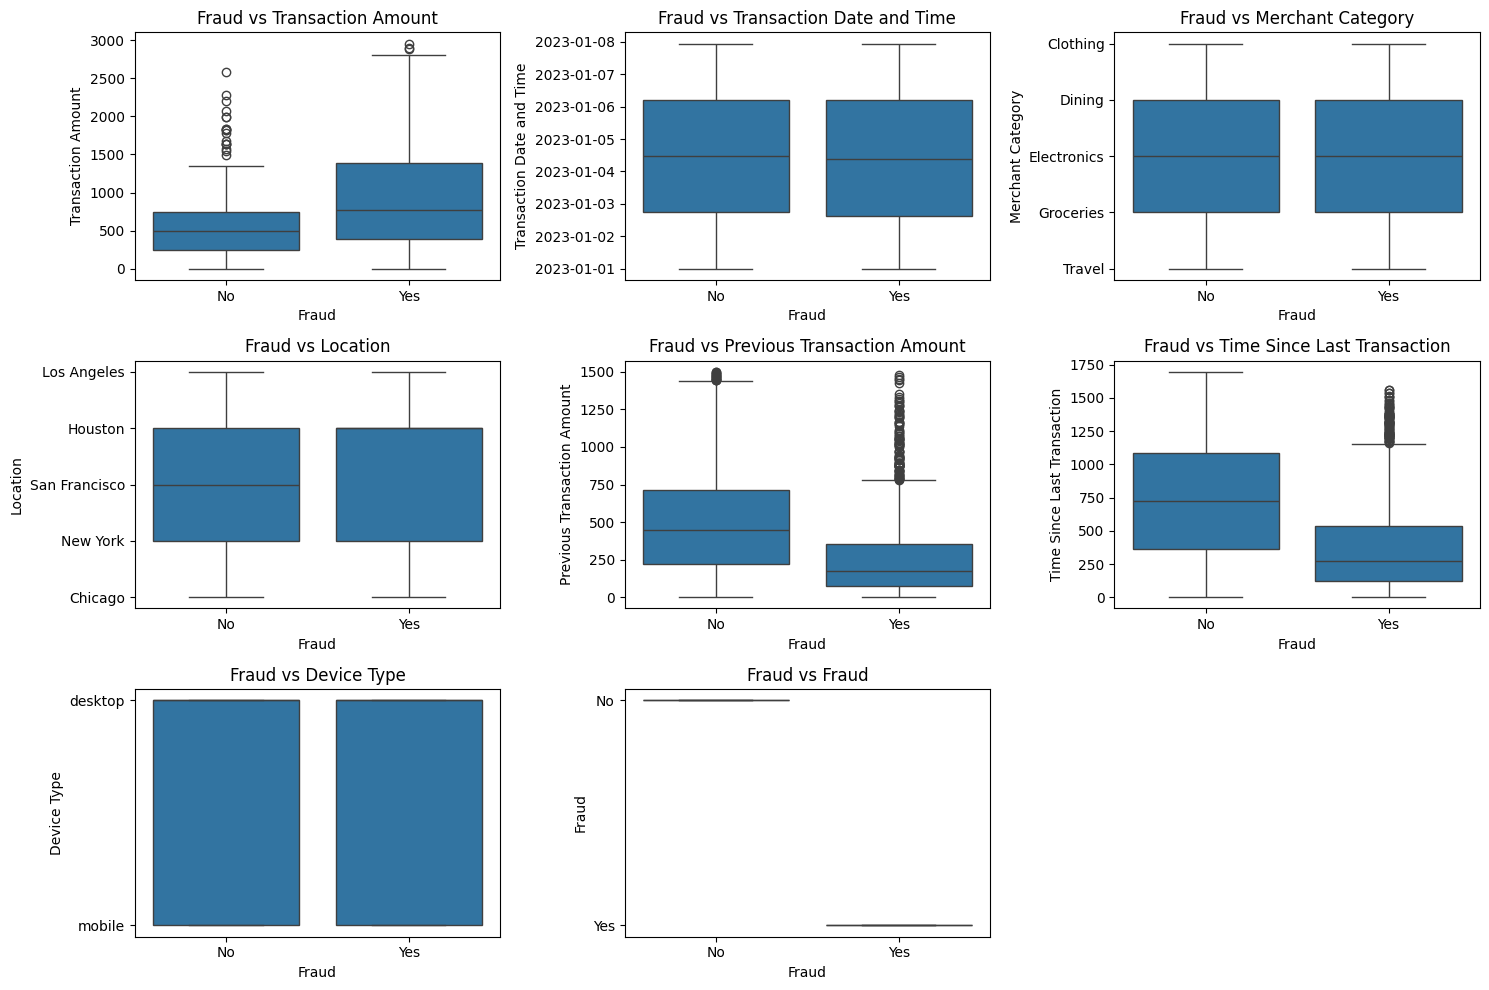

In [26]:
# Create a list of columns to plot against 'Fraud'
columns_to_plot = ['Transaction Amount','Transaction Date and Time','Merchant Category',
                   	'Location','Previous Transaction Amount','Time Since Last Transaction',	'Device Type','Fraud']

# Set up the matplotlib figure
plt.figure(figsize=(15, 10))

# Loop through the columns and create a box plot for each
for i, column in enumerate(columns_to_plot, 1):
    plt.subplot(3, 3, i)
    sns.boxplot(data=df, x='Fraud', y=column)
    plt.title(f'Fraud vs {column}')
    plt.tight_layout()

plt.show()

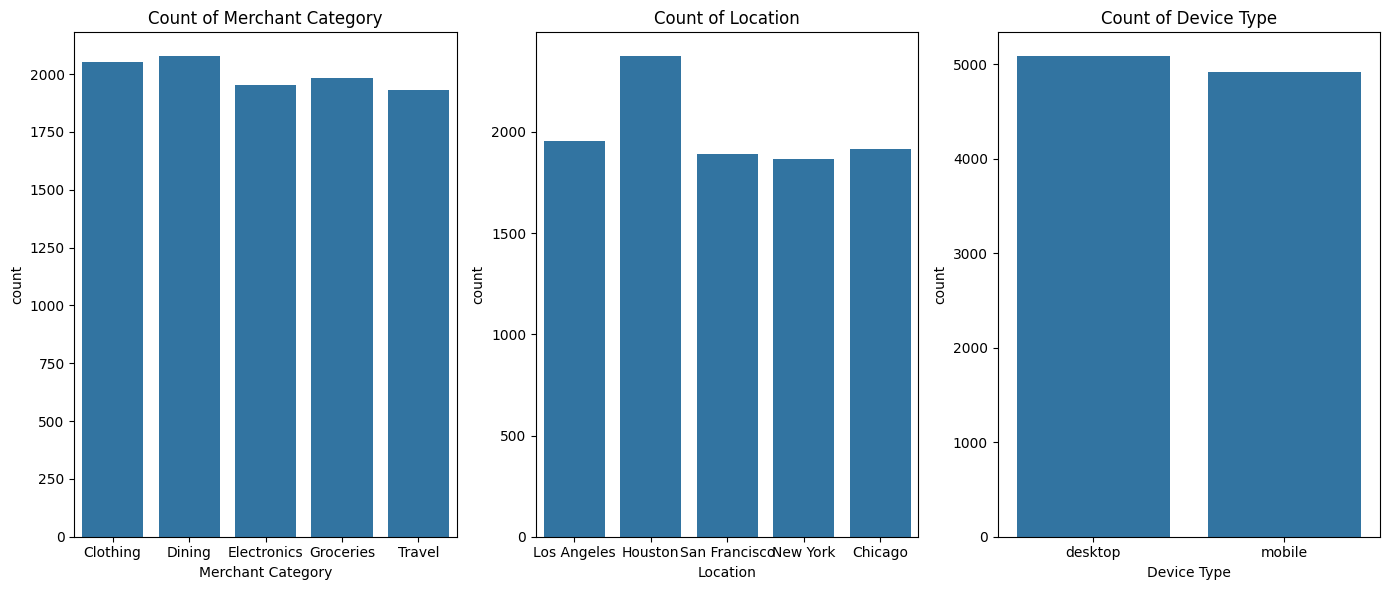

In [27]:
# histogram of cat
cat_cols = ['Merchant Category','Location','Device Type']

plt.figure(figsize=(14, 6))
for i, col in enumerate(cat_cols):
    plt.subplot(1, len(cat_cols), i+1)
    sns.countplot(x=data[col])
    plt.title(f'Count of {col}')
plt.tight_layout()
plt.show()


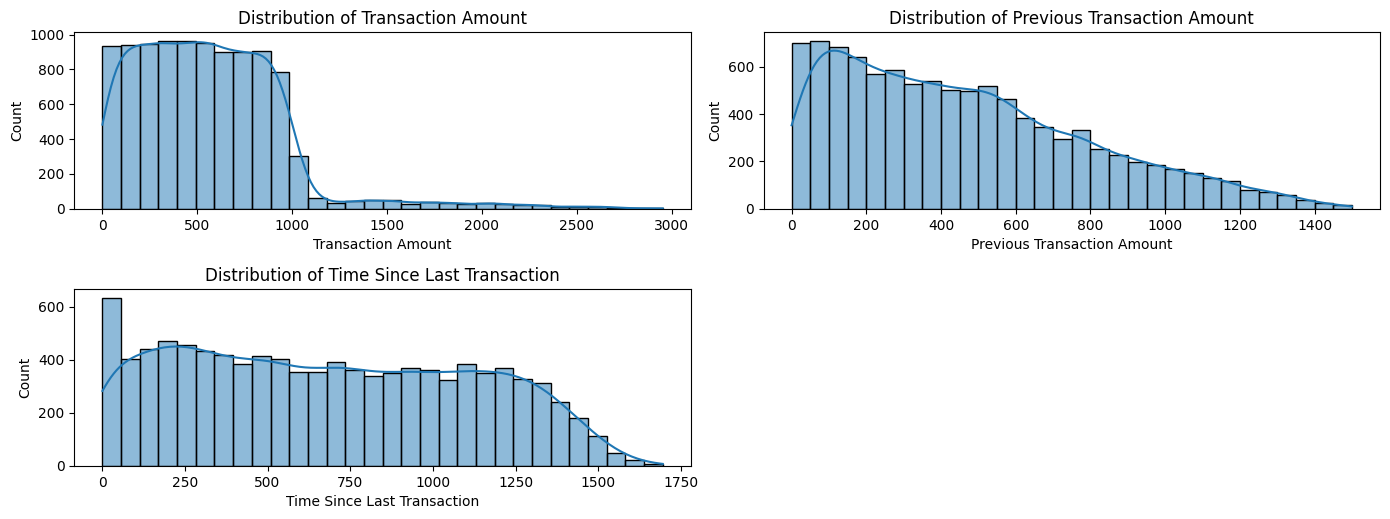

In [28]:
# histogram of num
num_cols = ['Transaction Amount','Previous Transaction Amount','Time Since Last Transaction']

plt.figure(figsize=(14, 10))
for i, col in enumerate(num_cols):
    plt.subplot(4, 2, i+1)
    sns.histplot(df[col], bins=30, kde=True)
    plt.title(f'Distribution of {col}')
plt.tight_layout()
plt.show()


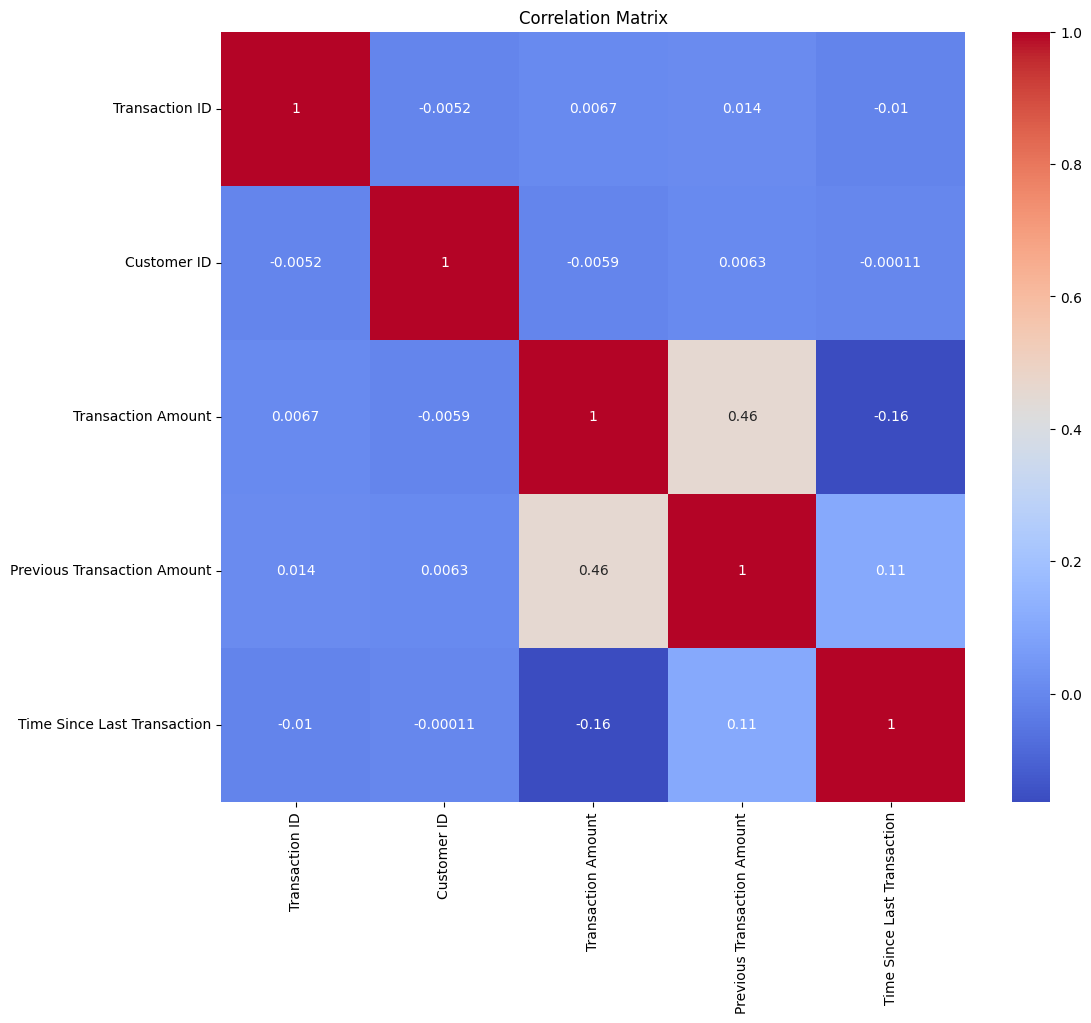

In [29]:
#heatmap
numeric_data = data.select_dtypes(include=['float64', 'int64'])
corr_matrix = numeric_data.corr()

plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

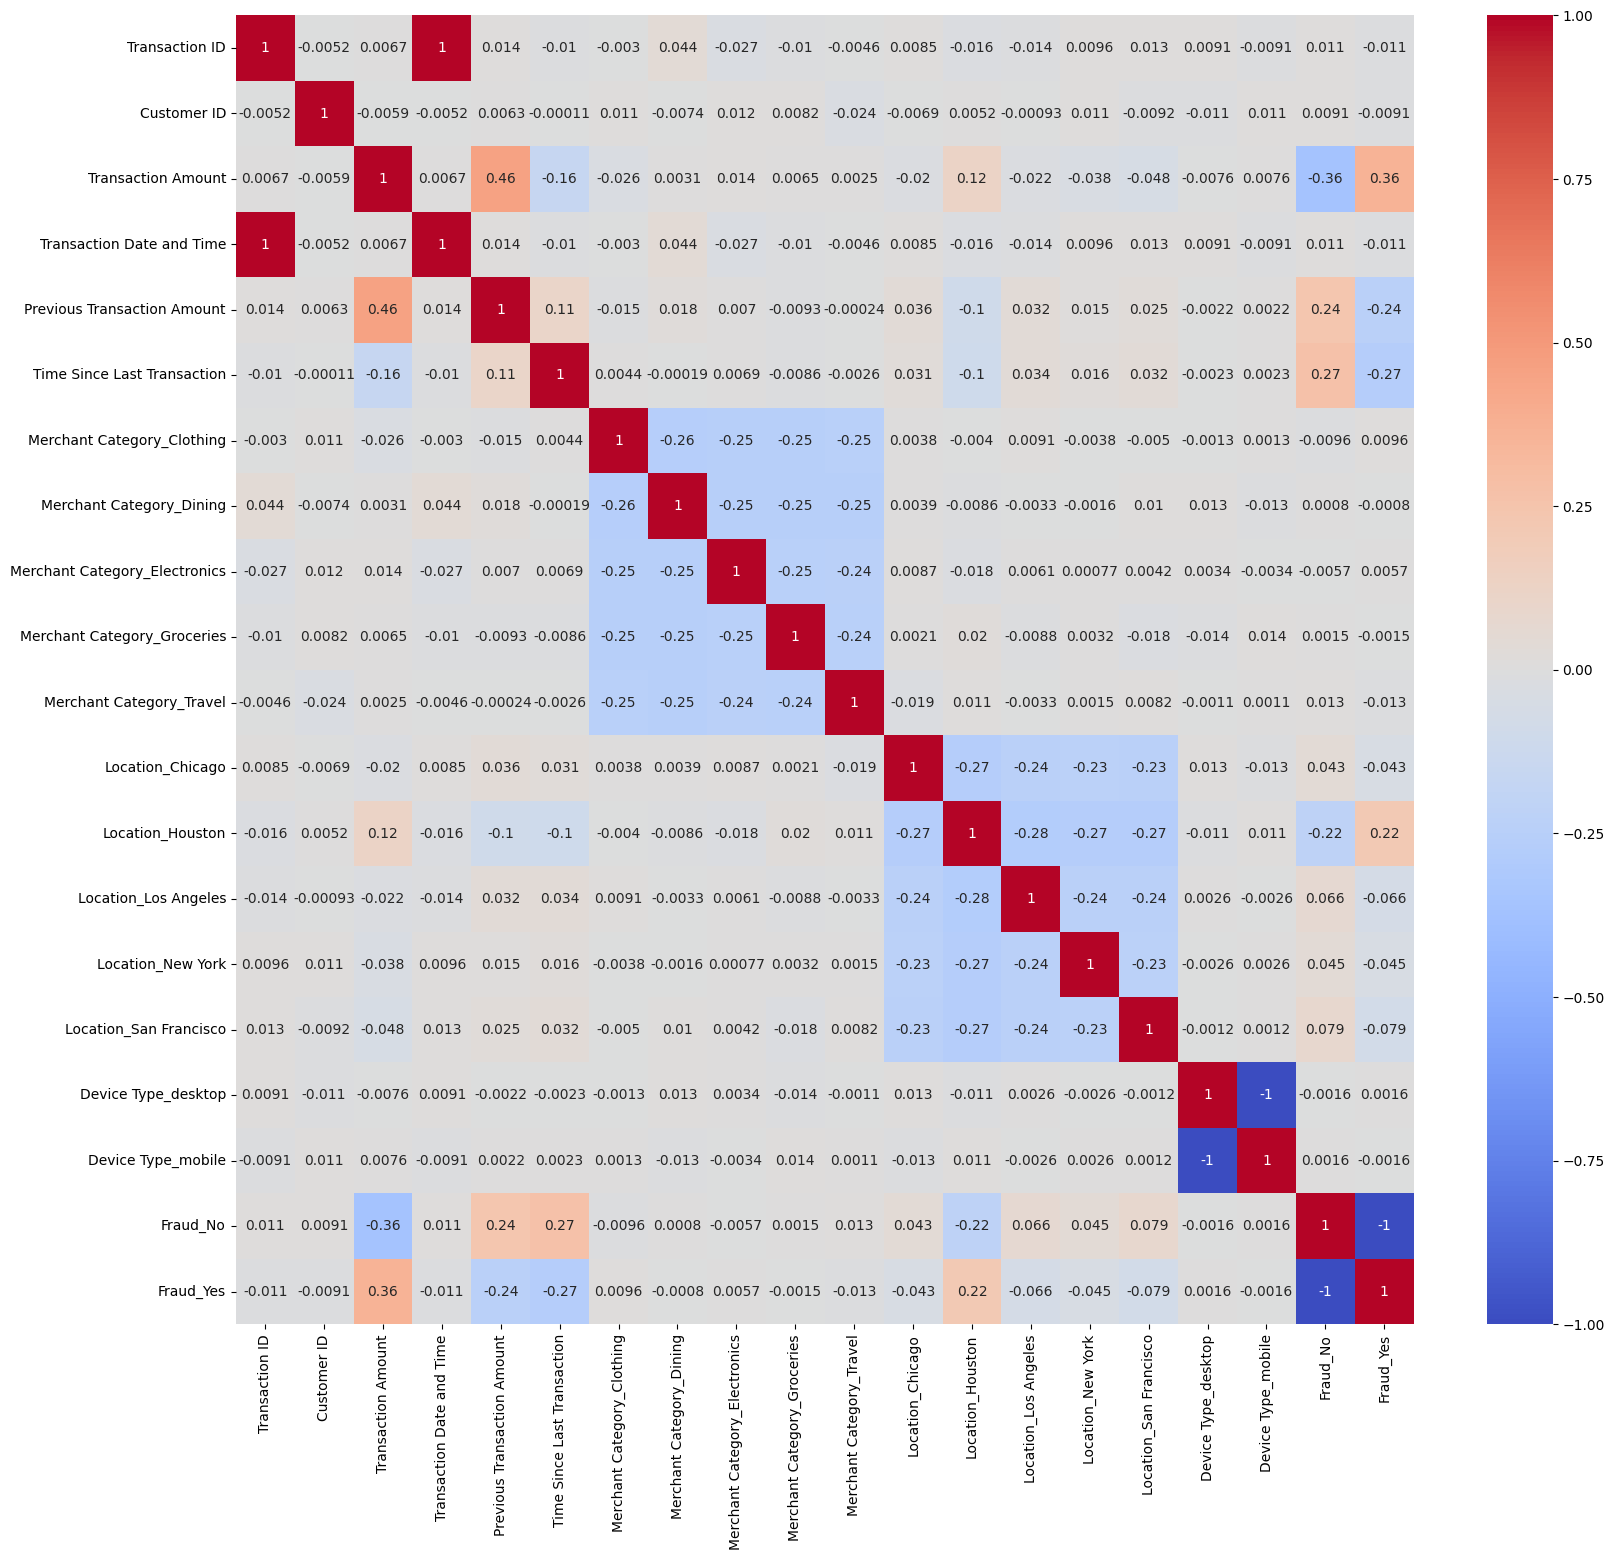

In [30]:
# Convert categorical variables to numeric using one-hot encoding
df_encoded = pd.get_dummies(df)

# Calculate correlation matrix
correlation_matrix = df_encoded.corr()

# Plot the correlation matrix
plt.figure(figsize=(19, 17))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.show()

Insight from heatmap: 'Transition amount'  has the most strong relationship with Fraud. Also, 'Previous Transaction Amount'and 'Time Since Last Transaction' and also have some relation with fraud

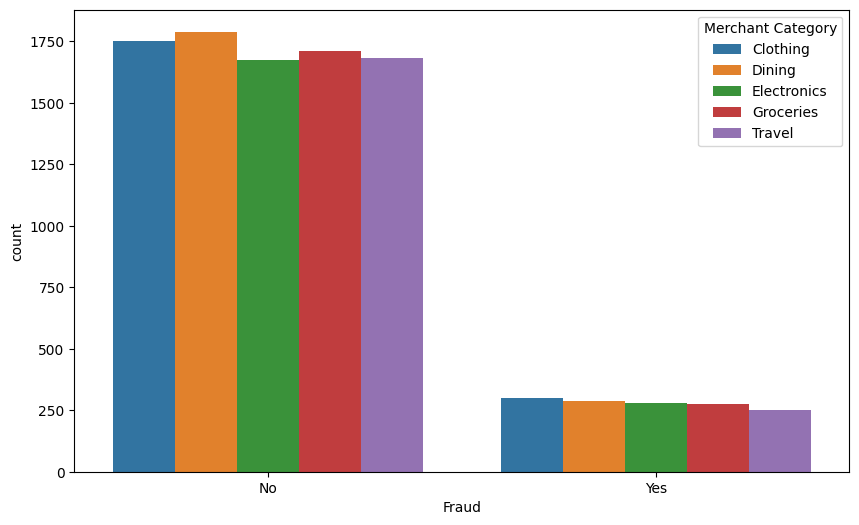

In [31]:
plt.figure(figsize=(10, 6))
sns.countplot(x='Fraud', hue='Merchant Category', data=df)
plt.show()

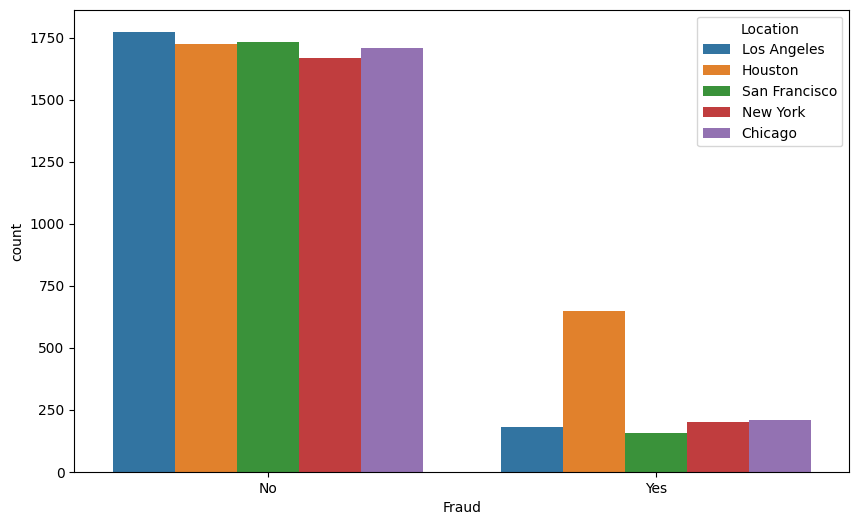

In [32]:
plt.figure(figsize=(10, 6))
sns.countplot(x='Fraud', hue='Location', data=df)
plt.show()

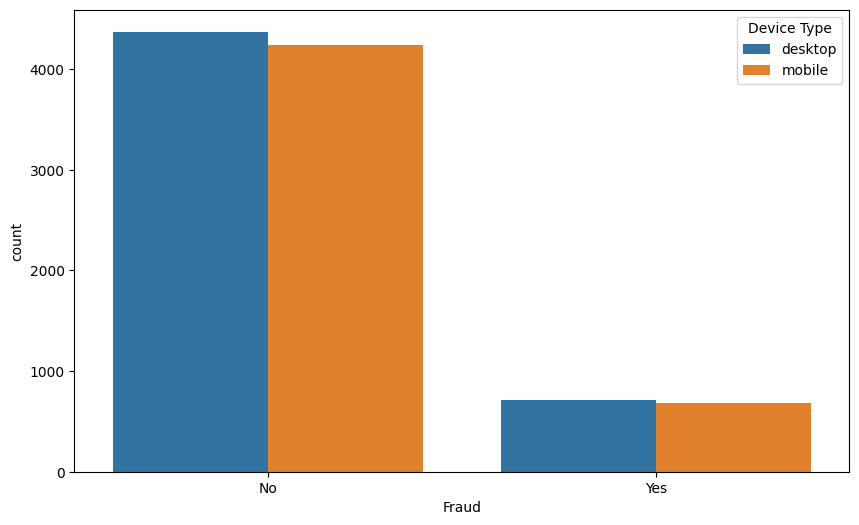

In [33]:
plt.figure(figsize=(10, 6))
sns.countplot(x='Fraud', hue='Device Type', data=df)
plt.show()

### Hypothesis: There is a positive correlation between the transition amount and fraud, that means the larger amout of transition will be easier identified as fraud.  

## Feature engineering

In [34]:
from sklearn.preprocessing import LabelEncoder

# Initialize the LabelEncoder
label_encoder = LabelEncoder()

# Label Encoding to the 'Merchant Category' & 'Location'
df['Merchant Category'] = label_encoder.fit_transform(df['Merchant Category'])
df['Location'] = label_encoder.fit_transform(df['Location'])


In [35]:
from sklearn.preprocessing import OneHotEncoder

# Hot Encoding to the 'Device Type' & 'Fraud'
df = pd.get_dummies(df, columns=['Device Type', 'Fraud'], drop_first=True)


In [36]:
# demonstrate what MinMaxScaler() does
MinMaxScaler().fit_transform(df[['Transaction Amount','Previous Transaction Amount','Time Since Last Transaction']])

array([[0.22297057, 0.3862158 , 0.28362347],
       [0.16022468, 0.27148018, 0.68382852],
       [0.16861553, 0.17705574, 0.42491033],
       ...,
       [0.29843464, 0.35415824, 0.10962137],
       [0.        , 0.        , 0.0681007 ],
       [0.05349904, 0.10114595, 0.10756374]])

In [38]:
columns = df.columns
print(columns)

Index(['Transaction ID', 'Customer ID', 'Transaction Amount',
       'Transaction Date and Time', 'Merchant Category', 'Location',
       'Previous Transaction Amount', 'Time Since Last Transaction',
       'Device Type_mobile', 'Fraud_Yes'],
      dtype='object')


In [39]:
# split data into X variables and y variable
x=df[['Transaction Amount','Merchant Category', 'Location',
       'Previous Transaction Amount', 'Time Since Last Transaction',
       'Device Type_mobile']]
y=df['Fraud_Yes']

In [40]:
# reserve 30% for testing
x_train, x_test, y_train, y_test = train_test_split(x,y, test_size=0.3, random_state=42)

In [41]:
numeric_columns = ['Transaction Amount','Previous Transaction Amount', 'Time Since Last Transaction']
categorical_columns = ['Merchant Category', 'Location', 'Device Type_mobile']

In [42]:
df.groupby('Fraud_Yes')['Fraud_Yes'].count()/len(df)
## The results shows the data is imbalanced

Fraud_Yes
False    0.8608
True     0.1392
Name: Fraud_Yes, dtype: float64

### The KNN is sensitive to the imbalanced data, so we cannot use this classificate model.
### Also, The result is the binary, so we can try logistic model, NB, and decision tree.

## Logistic

In [53]:
logreg = LogisticRegression()
logreg_scores = cross_val_score(logreg, x_train, y_train, scoring='f1', cv=5)

c:\Users\t\AppData\Local\R-MINI~1\lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\t\AppData\Local\R-MINI~1\lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-re

In [54]:
logreg.fit(x_train, y_train)
y_pred_logreg = logreg.predict(x_test)

c:\Users\t\AppData\Local\R-MINI~1\lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [55]:
print(accuracy_score(y_test, y_pred_logreg ))
print(f1_score(y_test, y_pred_logreg ))
print(precision_score(y_test, y_pred_logreg ))
print(recall_score(y_test, y_pred_logreg ))

print("Logistic Regression Classification Report:")
print(classification_report(y_test, y_pred_logreg))

0.9273333333333333
0.6426229508196721
0.9333333333333333
0.49
Logistic Regression Classification Report:
              precision    recall  f1-score   support

       False       0.93      0.99      0.96      2600
        True       0.93      0.49      0.64       400

    accuracy                           0.93      3000
   macro avg       0.93      0.74      0.80      3000
weighted avg       0.93      0.93      0.92      3000



## NB

In [58]:
nb = GaussianNB()
nb_scores = cross_val_score(nb, x_train, y_train, scoring='f1', cv=5)

In [59]:
nb.fit(x_train, y_train)
y_pred_nb = nb.predict(x_test)

In [60]:
# Report
print(accuracy_score(y_test, y_pred_nb))
print(f1_score(y_test, y_pred_nb))
print(precision_score(y_test, y_pred_nb))
print(recall_score(y_test, y_pred_nb))

print(classification_report(y_test, y_pred_nb))
print(confusion_matrix(y_test, y_pred_nb))


0.9116666666666666
0.5242369838420108
0.9299363057324841
0.365
              precision    recall  f1-score   support

       False       0.91      1.00      0.95      2600
        True       0.93      0.36      0.52       400

    accuracy                           0.91      3000
   macro avg       0.92      0.68      0.74      3000
weighted avg       0.91      0.91      0.89      3000

[[2589   11]
 [ 254  146]]


## Decision Tree

In [62]:
from sklearn.tree import DecisionTreeClassifier

dt = DecisionTreeClassifier(class_weight='balanced', random_state=42)

In [63]:
dt.fit(x_train, y_train)
pred_train1 = dt.predict(x_train)
pred_test1 = dt.predict(x_test)

In [64]:
# without constraints we can see the tree is perfectly fitted to the training data
print(accuracy_score(pred_train1, y_train))
print(accuracy_score(pred_test1, y_test))

1.0
0.8856666666666667


In [65]:
params = {'max_depth':[2,3,4,5,6,7,8]
          , 'min_samples_split': [8,10,15,20],
           'min_samples_leaf': [4, 8, 10, 20]}

In [66]:
from sklearn.model_selection import GridSearchCV
grid_search = GridSearchCV(dt, params, cv=5,verbose=1, scoring='accuracy')

In [67]:
grid_search.fit(x_train, y_train)

Fitting 5 folds for each of 112 candidates, totalling 560 fits


GridSearchCV(cv=5,
             estimator=DecisionTreeClassifier(class_weight='balanced',
                                              random_state=42),
             param_grid={'max_depth': [2, 3, 4, 5, 6, 7, 8],
                         'min_samples_leaf': [4, 8, 10, 20],
                         'min_samples_split': [8, 10, 15, 20]},
             scoring='accuracy', verbose=1)

In [68]:
print(grid_search.best_params_)

{'max_depth': 3, 'min_samples_leaf': 20, 'min_samples_split': 8}


In [69]:
dt = DecisionTreeClassifier(max_depth = 5, min_samples_leaf=8, min_samples_split=8,random_state=123)
dt = dt.fit(x_train, y_train)

In [70]:
print(accuracy_score(pred_test1, y_test))
print(f1_score(pred_test1, y_test))
print(precision_score(pred_test1, y_test))
print(recall_score(pred_test1, y_test))

print(classification_report(pred_test1, y_test))
print(confusion_matrix(pred_test1, y_test))

0.8856666666666667
0.5791411042944785
0.59
0.5686746987951807
              precision    recall  f1-score   support

       False       0.93      0.94      0.93      2585
        True       0.59      0.57      0.58       415

    accuracy                           0.89      3000
   macro avg       0.76      0.75      0.76      3000
weighted avg       0.88      0.89      0.88      3000

[[2421  164]
 [ 179  236]]


## Compare Three Models Results
### The dataset is imbalance, so the accuracy is not really reliable. Therefore, I use the F1 score as my key metric

In [71]:
# Compare the f1 scores of the models

print(f1_score(y_test, y_pred_logreg ))
print(f1_score(y_test, y_pred_nb))
print(f1_score(pred_test1, y_test))

0.6426229508196721
0.5242369838420108
0.5791411042944785


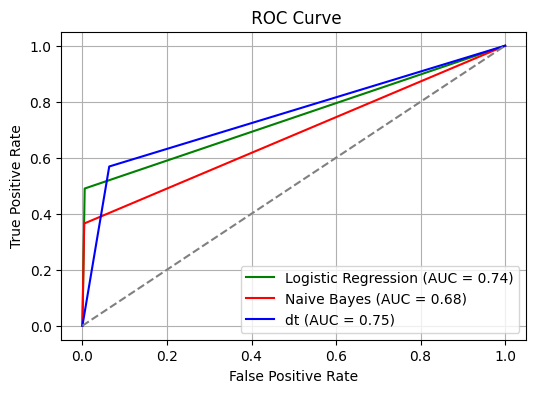

In [80]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

# Calculate ROC curves and AUC scores for each model

fpr_logreg, tpr_logreg, _ = roc_curve(y_test, y_pred_logreg)
roc_auc_logreg = roc_auc_score(y_test, y_pred_logreg)

fpr_nb, tpr_nb, _ = roc_curve(y_test, y_pred_nb)
roc_auc_nb = roc_auc_score(y_test, y_pred_nb)

fpr, tpr, _ = roc_curve(pred_test1, y_test)
roc_auc = roc_auc_score(pred_test1, y_test)

# Plot ROC curves
plt.figure(figsize=(6, 4))

plt.plot(fpr_logreg, tpr_logreg, color='green', label=f'Logistic Regression (AUC = {roc_auc_logreg:.2f})')
plt.plot(fpr_nb, tpr_nb, color='red', label=f'Naive Bayes (AUC = {roc_auc_nb:.2f})')
plt.plot(fpr, tpr, color='blue', label=f'dt (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(' ROC Curve')
plt.legend()
plt.grid()
plt.show()

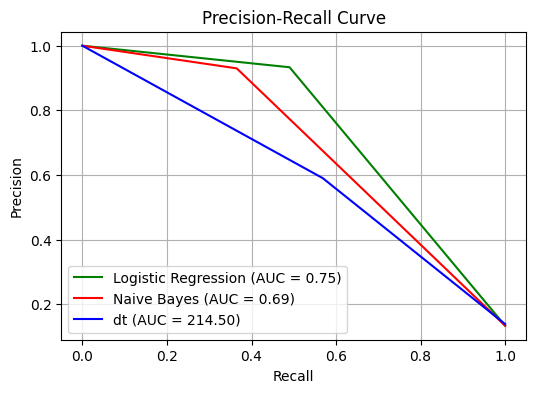

In [83]:
from sklearn.metrics import precision_recall_curve, auc

#Calculate precision-recall curve

precision_logreg, recall_logreg, _ = precision_recall_curve(y_test, y_pred_logreg)
pr_auc_logreg = auc(recall_logreg, precision_logreg)

precision_nb, recall_nb, _ = precision_recall_curve(y_test, y_pred_nb)
pr_auc_nb = auc(recall_nb, precision_nb)

precision, recall, _ = precision_recall_curve(pred_test1, y_test)
pr_auc_dt = auc(pred_test1, y_test)

# Plot precision-recall curve
plt.figure(figsize=(6, 4))

plt.plot(recall_logreg, precision_logreg, color='green', label=f'Logistic Regression (AUC = {pr_auc_logreg:.2f})')
plt.plot(recall_nb,precision_nb, color='red', label=f'Naive Bayes (AUC = {pr_auc_nb:.2f})')
plt.plot(recall,precision, color='blue', label=f'dt (AUC = {pr_auc_dt:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.grid()
plt.show()

### Based on above compare, I found the Logistic Modle have the best performance on F1 score and Pr curve.
### Although there the performance of logistic in ROC curve is not the best, the F1 performance is importance than other metrics in imbalance data.
### Therefore, I choose to use the logistic model as my final model.

## Improve the final choice(Logistic Model)

In [56]:
## improve logistic model

from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression

param_grid_logreg = {
    'penalty': ['l1', 'l2', 'elasticnet', 'none'],
    'C': [0.01, 0.1, 1, 10, 100],
    'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
    'max_iter': [100, 200, 300]
}

logreg = LogisticRegression()

# Hyperparameter search
grid_search_logreg = GridSearchCV(logreg, param_grid_logreg, cv=5, scoring='f1')
grid_search_logreg.fit(x_train, y_train)
print(f"Best Logistic Regression Parameters: {grid_search_logreg.best_params_}")


c:\Users\t\AppData\Local\R-MINI~1\lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\t\AppData\Local\R-MINI~1\lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\t\AppData\Local\R-MINI~1\lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\t\AppData\Local\R-MINI~1\lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\t\AppData\Local\R-MINI~1\lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\t\AppData\Local\R-MINI~1\lib\site-packages\sklearn\linea

Best Logistic Regression Parameters: {'C': 0.01, 'max_iter': 100, 'penalty': 'l2', 'solver': 'sag'}


c:\Users\t\AppData\Local\R-MINI~1\lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


In [84]:

# use the parameter 
best_logreg = LogisticRegression(**grid_search_logreg.best_params_)
best_logreg.fit(x_train, y_train)

# assessment Logistic Regression
logreg_best_scores = cross_val_score(best_logreg, x_train, y_train, scoring='f1', cv=5)
print(f"Best Logistic Regression Model F1 Score: {np.mean(logreg_best_scores)}")

# predict
y_pred_best_logreg = best_logreg.predict(x_test)


c:\Users\t\AppData\Local\R-MINI~1\lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\t\AppData\Local\R-MINI~1\lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\t\AppData\Local\R-MINI~1\lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\t\AppData\Local\R-MINI~1\lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\t\AppData\Local\R-MINI~1\lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\t\AppData\Local\R-MINI~1\lib\site-packages\sklearn\linea

Best Logistic Regression Model F1 Score: 0.7211720506030941


In [85]:
print(accuracy_score(y_test, y_pred_best_logreg))
print(f1_score(y_test, y_pred_best_logreg ))
print(precision_score(y_test, y_pred_best_logreg))
print(recall_score(y_test, y_pred_best_logreg ))

print("Improved Logistic Regression Classification Report:")
print(classification_report(y_test, y_pred_best_logreg))

0.9373333333333334
0.7098765432098766
0.9274193548387096
0.575
Improved Logistic Regression Classification Report:
              precision    recall  f1-score   support

       False       0.94      0.99      0.96      2600
        True       0.93      0.57      0.71       400

    accuracy                           0.94      3000
   macro avg       0.93      0.78      0.84      3000
weighted avg       0.94      0.94      0.93      3000



<Axes: >

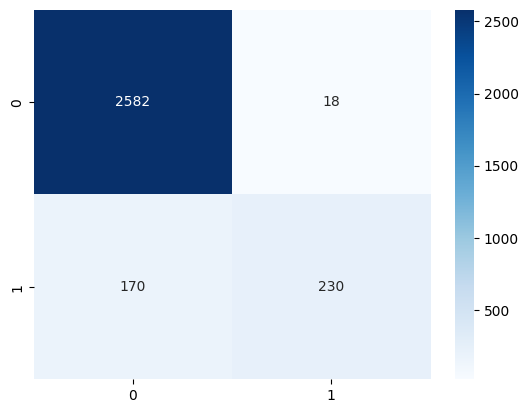

In [87]:
# Visualize the results: Confusion Matrix

cm=confusion_matrix(y_test,y_pred_best_logreg)
sns.heatmap(cm,annot=True,cmap='Blues',fmt='d')

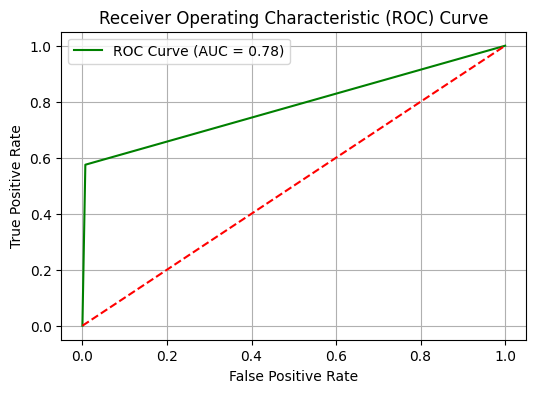

In [94]:
# Visualize the results: ROC Curve
# Calculate ROC curve and AUC
y_pred_prob = best_logreg.predict_proba(x_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test,  y_pred_best_logreg)
roc_auc = roc_auc_score(y_test, y_pred_best_logreg)

# Plot ROC curve
plt.figure(figsize=(6,4))
plt.plot(fpr, tpr, color='Green', label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='red', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.grid()
plt.show()

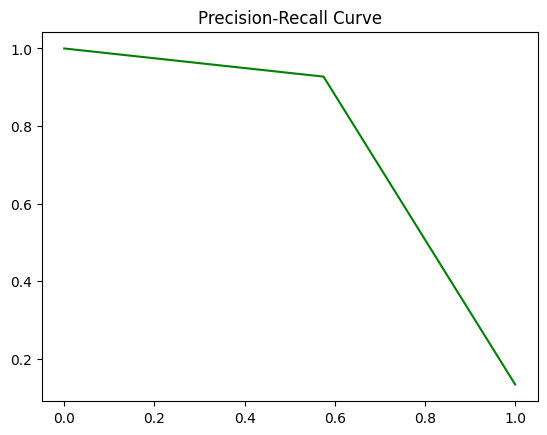

In [93]:
# Visualize the results: Precision-Recall Curve
# Calculate precision and recall
precision, recall, _ = precision_recall_curve(y_test, y_pred_best_logreg)

# Plot PR curve
plt.plot(recall_logreg, precision_logreg, color='green', label=f'Logistic Regression (AUC = {roc_auc:.2f})')
plt.title('Precision-Recall Curve')
plt.show()

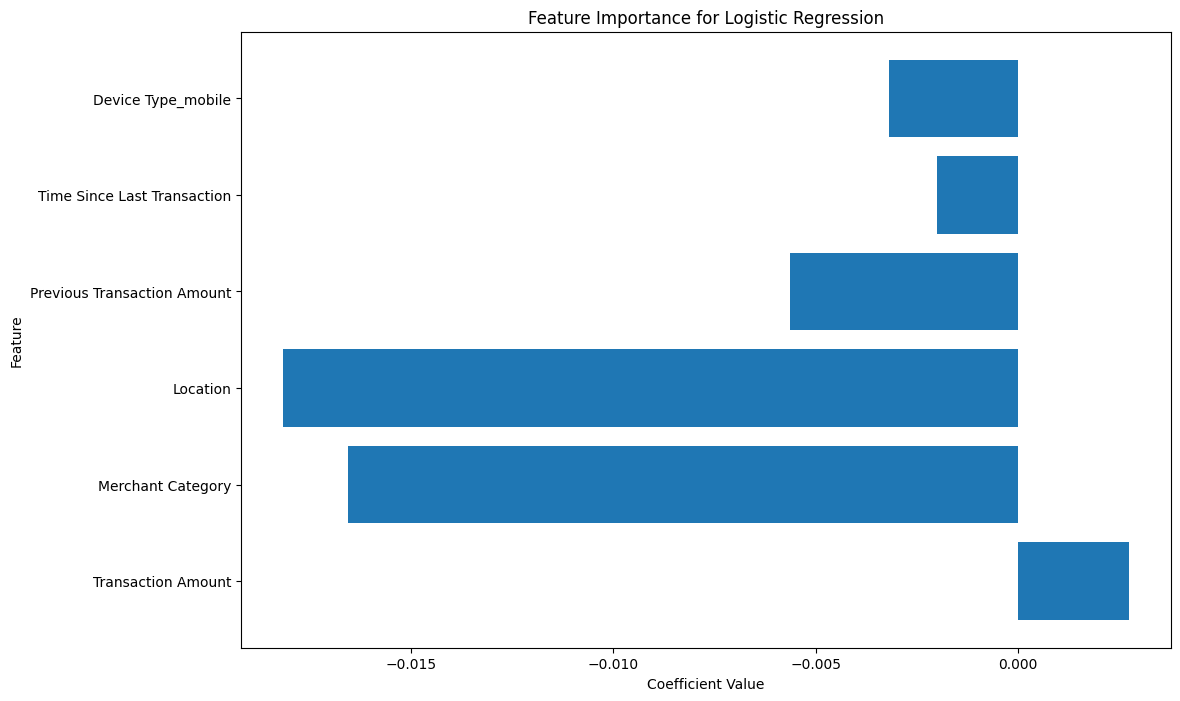

In [105]:

importance = best_logreg.coef_[0]
features = x.columns


# Display all coefficients together as well
plt.figure(figsize=(12, 8))
plt.barh(features, importance)
plt.title("Feature Importance for Logistic Regression")
plt.xlabel("Coefficient Value")
plt.ylabel("Feature")
plt.show()

## Explain of Coding
### i. Your data exploration findings, initial hypothesis, and whether the hypothesis proved true.
    ①Insight from EDA:
        -- 'Transition amount'  has the most strong relationship with Fraud. Also, 'Previous Transaction Amount'and 'Time Since Last Transaction' and also have some relation with fraud. Other factor's impact is not significant. 
        -- The dataset is imbalanced because Fraud_False has 86.08% and Fraud_True has 13.92%. 

    ②Hypothesis: There is a positive correlation between the transition amount and fraud, that means the larger amout of transition will be easier identified as fraud.  

    ③ Based on aboved analysis, I obvious that my Hypothesis is ture，and only this factor shows the positive relation with the fraud.

### ii. Your approach for building and evaluating the model. 
    ① First three model：First,The KNN is sensitive to the imbalanced data, so we cannot use this classificate model. Also, the output of my business problem is the binary, so I decide to try logistic model, NB, and decision tree.
    ② My input of the models are including 'Transaction Amount','Merchant Category', 'Location','Previous Transaction Amount', 'Time Since Last Transaction','Device Type_mobile'
    ③ Output is 'fraud_Yes'
### iii. The final model you selected and how you know this is the best model for the problem.
    ① Key Decision Metric：The dataset is imbalance, so the accuracy is not really reliable. Therefore, I use the F1 score as my key metric.
    ② Final Model：Based on above compare, I found the Logistic Modle have the best performance on F1 score and Pr curve. Although there the performance of logistic in ROC curve is not the best, the F1 performance is importance than other metrics in imbalance data. Therefore, I choose to use the logistic model as my final model.
    ③ Improve Approach：I use the GridSearch to find the best Hyperparameter in Logistic Model, the F1 Score improve from 64.26% to 70.98%. 

## iv. How the model should be used by the business, in business process.
    ① The results show the factor of 'Transition amount' need to pay attention in the fraudulent credit card transactions. If the company need to reduce the number of legitimate transactions flagged as fraud, they can more focus on the large amount transition. This can help in fine-tuning fraud detection mechanisms and reducing false positives.
    ② The model also analyzed the characteristics of fraudulent transactions to determine if there are specific customer groups that may be at risk of fraud. In dataset like 'Location_houston' and 'High transition amount' need to be pay attention, and these characteristics of customers will be marked as high risk This helps to tailor anti fraud measures for different customer groups.
    ③ The company also can actively customer communication. For transactions marked as high risk, the company can proactively contact customers for verification.





